# Image Binary Classification with Standard Deep Neural Network

## 1. Introduction

Given a dataset containing:
   - a training set ("train_catvnoncat.h5") of m_train images labeled as cat (y=1) or non-cat (y=0)
   - a test set ("test_catvnoncat.h5") of m_test images labeled as cat or non-cat
   - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px and width = num_px).

We will build a deep neural network model that can correctly classify pictures as cat or non-cat.

## 2. Import Packages and Set Default Parameters

- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- util_func provides some necessary functions for the calculations, e.g., Sigmoid, RELU.
- deep_neural_network.py provides the functions to construct deep neural network.


In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import math
import numpy as np
import matplotlib.pyplot as plt 
from deep_neural_network import *
from IPython.display import HTML
import h5py

plt.rcParams['figure.figsize'] = (6.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray' # set colormap

In [2]:
np.random.seed(20)

## 3. Load the Data

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

In [3]:
# load training and test data, and list of classes

def load_data():
    """
    Returns:
    train_x_orig: numpy array, original training set features 
    train_y_orig: numpy array, original training set labels 
    test_x_orig: numpy array, original test set features 
    test_y_orig: numpy array, original test set labels 
    classes: numpy array, list of classes  
    """
    # training set:
    train_data = h5py.File('data/train_catvnoncat.h5', 'r')
    train_x_orig = np.array(train_data['train_set_x']) # training set features
    train_y_orig = np.array(train_data['train_set_y']) # training set labels
    # test set:
    test_data = h5py.File('data/test_catvnoncat.h5', 'r')
    test_x_orig = np.array(test_data['test_set_x']) # test set features
    test_y_orig = np.array(test_data['test_set_y']) # test set labels
    # list of classes
    classes = np.array(test_data['list_classes'])
    # reshape the labels, make sure the dimension is (1, number of examples)
    train_y_orig = train_y_orig.reshape(1, train_y_orig.shape[0])
    test_y_orig = test_y_orig.reshape(1, test_y_orig.shape[0])
    
    return train_x_orig, train_y_orig, test_x_orig, test_y_orig, classes    

In [4]:
# load the data

train_x_orig, train_y_orig, test_x_orig, test_y_orig, classes = load_data()
print("Total number of training examples: " + str(train_x_orig.shape[0]))
print("Total number of test examples: " + str(test_x_orig.shape[0]))
print("Size of each image: " + str(train_x_orig[0].shape))
print("All classes: " + str(classes))
print("train_x_orig shape: " + str(train_x_orig.shape))
print("train_y_orig shape: " + str(train_y_orig.shape))
print("test_x_orig shape: " + str(test_x_orig.shape))
print("test_y_orig shape: " + str(test_y_orig.shape))

Total number of training examples: 209
Total number of test examples: 50
Size of each image: (64, 64, 3)
All classes: [b'non-cat' b'cat']
train_x_orig shape: (209, 64, 64, 3)
train_y_orig shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y_orig shape: (1, 50)


In [5]:
# show some examples of the images in the training set

def example(indices, X, Y, classes):
    """
    Arguments:
    indices: list of the indices of X to be shown
    X: numpy array, image fearues, with the shape of (number of examples, num_px, num_px, 3)
    Y: numpy array, image classes, with the shape of (1, number of examples)
    classes: numpy array, list of classes
    """
    
    num = len(indices)
    columns = 5 # the number of columns to arrange the figures
    plt.figure(figsize = (20, 12))
    for i in range(num):
        plt.subplot(math.ceil(num / columns), columns, i + 1)
        plt.imshow(X[indices[i]])
        plt.axis('off')
        # decode('utf-8') converts from unicode (numpy.bytes) to string
        plt.title("Index = " + str(indices[i]) + ", class: " + classes[Y[0, indices[i]]].decode('utf-8'))

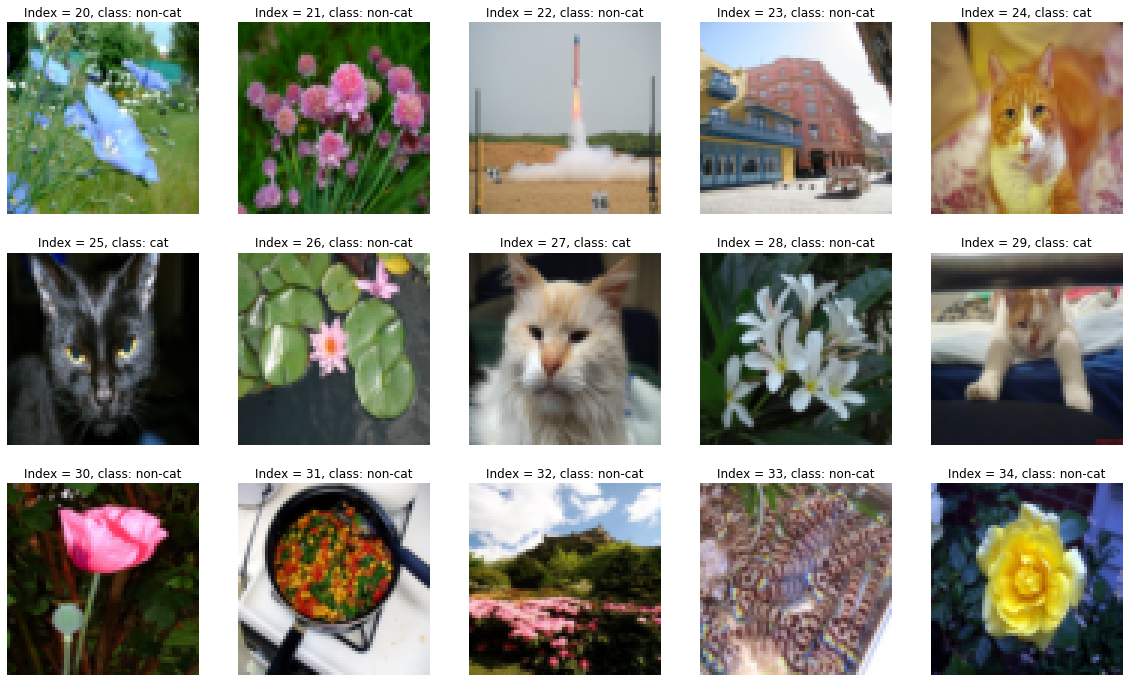

In [6]:
indices = [i for i in range(20, 35, 1)]
example(indices, train_x_orig, train_y_orig, classes)

## 4. Data Pre-Processing

We reshape and standardize the images before feeding them to the network.

<img src="images/imvector.png" style="width:450px;height:300px;">

One common preprocessing step in machine learning is to center and standardize our dataset, meaning that we substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every pixel value by 255 (the maximum value of a pixel channel).

**Note** that it is extremely important for each feature to have a similar range such that our gradients don't explode.

$12,288$ equals $64 \times 64 \times 3$ which is the size of one reshaped image vector.

In [7]:
# pre-processing the features

# convert image features from (num_px, num_px, 3) to 1-D vector:
train_x = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# standardize, so the values are between 0 and 1.
train_x = train_x / 255
test_x = test_x / 255

# format of labels remain the same
train_y = train_y_orig
test_y = test_y_orig

print("64 x 64 x 3 = " + str(64 * 64 * 3))
print("dimension of train_x: " + str(train_x.shape))
print("dimension of test_x: " + str(test_x.shape))

64 x 64 x 3 = 12288
dimension of train_x: (12288, 209)
dimension of test_x: (12288, 50)


## 5.  Model Architecture

We build an L-layer deep neural network to distinguish cat images from non-cat images.

Here is a simplified network representation:

<img src="images/LlayerNN.png" style="width:650px;height:400px;">

<u>Detailed Architecture</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then we add the bias $b^{[1]}$. The result is called the linear unit.
- Next, we take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, we take the sigmoid of the final linear unit. If it is greater than 0.5, we classify it to be a cat.

## 6. Model Training

We follow the usual Deep Learning methodology to build the model:
   1. Initialize parameters / Define hyperparameters
   2. Loop for num_iterations:
          a. Forward propagation
          b. Compute cost function
          c. Backward propagation
          d. Update parameters
   3. Use trained parameters to predict labels

current iteration: 1, cost: 0.7003462391104095
current iteration: 660, cost: 0.3575750218870119
current iteration: 1320, cost: 0.15942891915424143
current iteration: 1980, cost: 0.10647548890825623
current iteration: 2640, cost: 0.08216201037967218
current iteration: 3300, cost: 0.02347300805502238


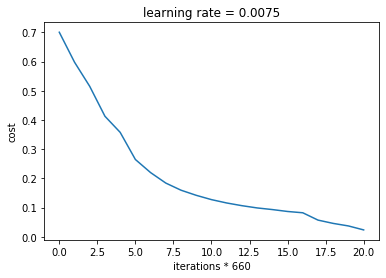

In [8]:
layer_dims = [12288, 20, 7, 5, 1] # number of units in each layer, including the input and output layers

# train the neural network
params = L_layer_model(train_x, train_y, layer_dims, params_seed = 20, learning_rate = 0.0075, iterations = 3300, 
                       print_cost_freq = 660, save_cost_freq = 165, initialization = "he")

In [9]:
# use the trained params to predict

def predict(params, X, Y):
    """
    Arguments: 
    X: input features
    params: trained weight matrices and bias vectors of the neural network
    Y: true labels, used to calculate the accuracy
    
    Returns:
    predicted labels for X
    """
   
    Aout, _ = L_layer_forward(X, params)
    m = X.shape[1] # number of examples
    Aout.reshape(1, m)
    Aout = (Aout > 0.5)
   
    print("Accuracy: " + str(np.sum(Aout == Y) / m))
    
    return Aout

In [10]:
# model accuracy for training set

print('Training Set:')
predicted_train_y = predict(params, train_x, train_y)

Training Set:
Accuracy: 0.9952153110047847


In [11]:
# model accuracy for test set

print('Test Set:')
predicted_test_y = predict(params, test_x, test_y)

Test Set:
Accuracy: 0.78


**Note**: We may notice that running the model on fewer iterations gives better accuracy on the test set. This is called "early stopping". Early stopping is a way to prevent overfitting. 

## 7. Result Analysis

### 7.1 Mislabeled Examples in the Test Set
First, let's take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images.

In [12]:
# show some mislabeled images

def mislabeled_example(X, Y, predicted_Y, classes, max_examples):
    """
    Arguments:
    X: input features, numpy array of shape (number of features, number of examples)
    Y: true labels
    predicted_Y: predicted labels
    max_examples: maximum number of examples to be shown
    """
    columns = 5 # number of columns to arrange the figures
    plt.figure(figsize = (20, 12))
    
    mislabeled_indices = np.asarray(np.where(Y + predicted_Y == 1))
    
    num = min(len(mislabeled_indices[1, :]), max_examples)# determine the number of examples to be shown
    
    for i in range(num):
        plt.subplot(math.ceil(num / columns), columns, i + 1)
        plt.imshow(X[:, mislabeled_indices[1, i]].reshape(64, 64, 3))
        plt.axis('off')
        # pridicted_Y's datatype could be float, convert to int
        plt.title("predicted class: " + classes[int(predicted_Y[0, mislabeled_indices[1, i]])].decode('utf-8') + 
                 "\n actual class: " + classes[int(Y[0, mislabeled_indices[1, i]])].decode('utf-8'))
    

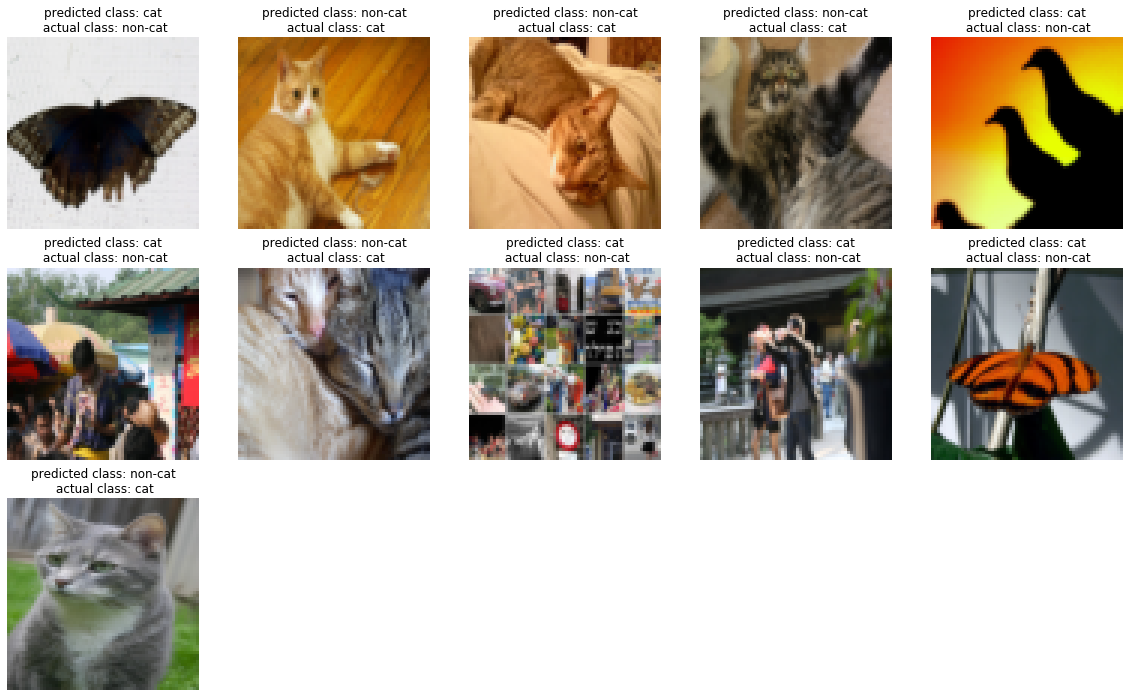

In [13]:
mislabeled_example(test_x, test_y, predicted_test_y, classes, 15)

**A few types of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

### 7.2 Test with Our Own Image

We can use our own image and see the output of the model. To do that:
   1. Click on "File" in the upper bar of this notebook, then click "Open".
   2. Add our image to this Jupyter Notebook's directory, in the "images" folder
   3. Change the image's name in the following code

In [14]:
# use my own image to test the model

from skimage.transform import resize

def test_own(fname, label, classes, num_px):
    """
    Arguments:
    fname: file path and name
    label: true label of the image. 1: cat, 0: non-cat
    num_px: pixel value. The image size is converted to (num_px, num_px, 3)
    """
    plt.figure()
    image_orig = np.array(plt.imread(fname, format = 'RGB'))
    # Resize image to match a certain size, already normalized so the value are between 0 and 1
    image = resize(image_orig, (num_px, num_px)).reshape(num_px * num_px * 3, 1)
    predicted_Y = predict(params, image, label)
    
    plt.imshow(image_orig)
    plt.axis('off')
    plt.title("Predicted Class: " + classes[int(np.squeeze(predicted_Y))].decode('utf-8') + 
                 "\n Actual Class: " + classes[label].decode('utf-8'))

Accuracy: 0.0
Accuracy: 0.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0


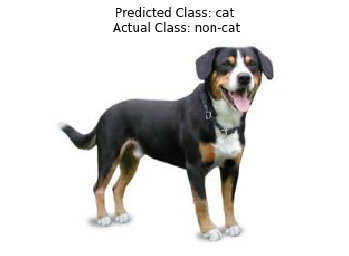

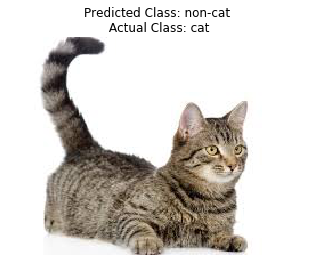

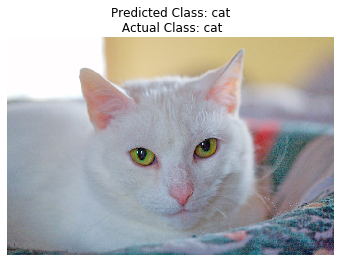

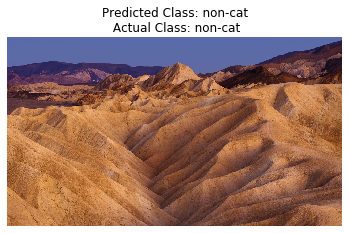

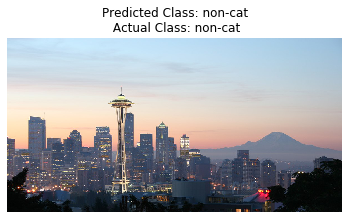

In [15]:
test_own("images/dog.jpg", 0, classes, 64)
test_own("images/cat.jpg", 1, classes, 64)
test_own("images/cat1.jpg", 1, classes, 64)
test_own("images/scene.jpg", 0, classes, 64)
test_own("images/seattle.jpg", 0, classes, 64)